In [1]:
'''

Much of this code is adapted from code written by 
Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
'''


import keras.backend as K
import tensorflow as tf
from keras import initializers, layers, activations
from keras.regularizers import l2


class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    
    Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param num_routing: number of iterations for the routing algorithm

    Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
    """
    def __init__(self, num_capsule, dim_capsule, num_routing=3,
                 kernel_initializer='glorot_uniform', kernel_regularizer=l2(1e-2),
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = kernel_regularizer

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 regularizer=self.kernel_regularizer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        inputs_expand = K.expand_dims(inputs, 1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule]
        inputs_tiled = K.tile(inputs_expand, [1, self.num_capsule, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs_tiled)

        """
        # Begin: routing algorithm V1, dynamic ------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        b = K.zeros(shape=[self.batch_size, self.num_capsule, self.input_num_capsule])

        def body(i, b, outputs):
            c = tf.nn.softmax(b, dim=1)  # dim=2 is the num_capsule dimension
            outputs = squash(K.batch_dot(c, inputs_hat, [2, 2]))
            if i != 1:
                b = b + K.batch_dot(outputs, inputs_hat, [2, 3])
            return [i-1, b, outputs]

        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), b, K.sum(inputs_hat, 2, keepdims=False)]
        shape_invariants = [tf.TensorShape([]),
                            tf.TensorShape([None, self.num_capsule, self.input_num_capsule]),
                            tf.TensorShape([None, self.num_capsule, self.dim_capsule])]
        _, _, outputs = tf.while_loop(cond, body, loop_vars, shape_invariants)
        # End: routing algorithm V1, dynamic ------------------------------------------------------------#
        """
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # In forward pass, `inputs_hat_stopped` = `inputs_hat`;
        # In backward, no gradient can flow from `inputs_hat_stopped` back to `inputs_hat`.
        inputs_hat_stopped = K.stop_gradient(inputs_hat)
        
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule])

        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            # c.shape=[batch_size, num_capsule, input_num_capsule]
            c = tf.nn.softmax(b, dim=1)

            # At last iteration, use `inputs_hat` to compute `outputs` in order to backpropagate gradient
            if i == self.num_routing - 1:
                # c.shape =  [batch_size, num_capsule, input_num_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
                # outputs.shape=[None, num_capsule, dim_capsule]
                outputs = squash(K.batch_dot(c, inputs_hat, [2, 2]))  # [None, 10, 16]
            else:  # Otherwise, use `inputs_hat_stopped` to update `b`. No gradients flow on this path.
                outputs = squash(K.batch_dot(c, inputs_hat_stopped, [2, 2]))

                # outputs.shape =  [None, num_capsule, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, num_capsule, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat_stopped, [2, 3])
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])
    
class GraphCapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param num_routing: number of iterations for the routing algorithm

    Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
    """
    def __init__(self, num_capsule, dim_capsule, num_routing=3,
                 kernel_initializer='glorot_uniform', kernel_regularizer=l2(1e-4),
                 **kwargs):
        super(GraphCapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = kernel_regularizer

    def build(self, input_shape):
        assert len(input_shape) >= 4, "The input Tensor should have shape=[None, N, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[2]
        self.input_dim_capsule = input_shape[3]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 regularizer=self.kernel_regularizer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, N, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, N, 1, input_num_capsule, input_dim_capsule]
        inputs_expand = K.expand_dims(inputs, 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, N, num_capsule, input_num_capsule, input_dim_capsule]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = K.map_fn(lambda x: 
                              K.map_fn(lambda y: K.batch_dot(y, self.W, [2, 3]), elems=x), elems=inputs_tiled)
        
            # Begin: Routing algorithm ---------------------------------------------------------------------#
        # In forward pass, `inputs_hat_stopped` = `inputs_hat`;
        # In backward, no gradient can flow from `inputs_hat_stopped` back to `inputs_hat`.
        inputs_hat_stopped = K.stop_gradient(inputs_hat)
        
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, N, self.num_capsule, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], K.shape(inputs_hat)[1],
                            self.num_capsule, self.input_num_capsule])

        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            # c.shape=[batch_size, num_capsule, input_num_capsule]
            c = tf.nn.softmax(b, dim=2)

            # At last iteration, use `inputs_hat` to compute `outputs` in order to backpropagate gradient
            if i == self.num_routing - 1:
                # c.shape =  [batch_size, num_capsule, input_num_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
                # outputs.shape=[None, num_capsule, dim_capsule]
                outputs = squash(K.batch_dot(c, inputs_hat, [3, 3]))  # [None, 10, 16]
            else:  # Otherwise, use `inputs_hat_stopped` to update `b`. No gradients flow on this path.
                outputs = squash(K.batch_dot(c, inputs_hat_stopped, [3, 3]))

                # outputs.shape =  [None, num_capsule, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, num_capsule, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat_stopped, [3, 4])
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple(list(input_shape[:2]) + [self.num_capsule, self.dim_capsule])

Using TensorFlow backend.


In [2]:



def PrimaryCap(x, L, dim_capsule, num_capsule, kernel_size, activation=None):
    """
    Apply GraphConv `n_channels` times and concatenate all capsules
    :param inputs: 3D tensor, shape=[None, N, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]

    Author: David McDonald, E-mail: `dxm237@cs.bham.ac.uk`
    """
    output = GraphConv(num_filters=dim_capsule*num_capsule, 
                       kernel_size=kernel_size, activation=activation,
                           name='primarycap_GraphConv')([L, x])
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

# class GraphConv(layers.Layer):
#     """
#     A layer to perform a convolutional filter on a graph

#     :param L_hat: rescaled graph laplacian: L_hat = 2L/lambda_max - identity(N)
#     :param num_filters: number of filters
#     :param kernel_size: size of kernel to use
    
#     Author: David McDonald, Email: `dxm237@cs.bham.ac.uk'
#     """
#     def __init__(self, new_dim, num_neighbours, num_filters, kernel_size, activation=None,
#                  kernel_initializer='glorot_uniform', kernel_regularizer=l2(1e-3),
#                  **kwargs):
#         super(GraphConv, self).__init__(**kwargs)

#         self.new_dim = new_dim
#         self.num_neighbours = num_neighbours
#         self.num_filters = num_filters
#         self.kernel_size = kernel_size
#         self.activation = activation
#         self.kernel_initializer = initializers.get(kernel_initializer)
#         self.kernel_regularizer = kernel_regularizer

#     def build(self, input_shape):
#         '''
#         L input shape[0] = [batch_size, Nn+1, Nn]
#         x input_shape[1] = [batch_size, Nn, D, input_channels]
#         '''
        
# #         _, Nn_plus_1, _ = input_shape[0]
#         _, _, D, num_channels = input_shape[1]
        
#         # chebyshev co-efficients
#         self.chebyshev_cofficient_matrix = self.add_weight(shape=[num_channels * (self.kernel_size + 0), 
#                                   self.num_filters],
#                                  initializer=self.kernel_initializer, regularizer=self.kernel_regularizer,
#                                  name='chebyshev_co-efficients')
        
#         # dimensionality reduction
#         self.W = self.add_weight(shape=[D, self.new_dim], 
#                                  initializer=self.kernel_initializer, regularizer=self.kernel_regularizer,
#                                  name="w")
        
#         # bias term ?
#         self.bias = self.add_weight(shape=[1, 1, self.new_dim, 1], 
#                                     initializer=self.kernel_initializer, regularizer=self.kernel_regularizer,
#                                    name="bias")

#         self.built = True
        
#     def compute_Lx(self, L, x):
        
#         '''
#         L.shape = [B, Nn+1, Nn]
#         x.shape = [B, Nn, D, C]
        
#         reshape x to [B, Nn, D*C]
#         matmul with L: [N, N] @ [N, D*C] -> [N, D*C]
#         reshape to [N, D, C]
        
#         '''
        
#         B = K.shape(x)[0]
#         Nn = K.shape(x)[1]
#         D = K.shape(x)[2]
#         C = K.shape(x)[3]
#         Nn_plus_1 = K.shape(L)[1]
        
#         x_transformed = x
# #         x_transformed = K.permute_dimensions(x_transformed, [1,0,2])
#         x_transformed = K.reshape(x_transformed, [B, Nn, D*C])
#         x_transformed = K.batch_dot(L, x_transformed)
# #         x_transformed =  K.reshape(x_transformed, [N, D, C])
# #         return K.permute_dimensions(x_transformed, [1, 0, 2])
#         return K.reshape(x_transformed, [B, Nn_plus_1, D, C])
        
#     def compute_x_hat(self, L, x):
#         '''
#         efficient computation of filter using recurrence relation of Chebyshev polynomials
#         T_k(x) = 2xT_k-1(x) - T_k-2(x)
#         T_0(x) = 1
#         T_1(x) = x
        
#         input shape is [None, Nn, D, input_channels]
#         output shape is [None, Nn+1, D, filters]
        
#         '''

# #         x_hat = [x]
#         x_hat = []
        
#         if self.kernel_size > 0:
#             x_hat.append(self.compute_Lx(L, x))
        
#         for k in range(self.kernel_size - 1):
#             x_hat.append(2 * self.compute_Lx(L, x_hat[-1]) - x_hat[-2])
    
#         # concatenate to combine input_channels and kernel_size axes
#         return K.concatenate(x_hat, axis=-1)
        
#     def linear_dimensionality_reduce(self, x):
        
#         # x.shape = [N, Nn+1, D, F]
#         x_transformed = K.permute_dimensions(x, [0,1,3,2])
#         x_transformed = K.dot(x_transformed, self.W)
        
#         return K.permute_dimensions(x_transformed, [0,1,3,2])

#     def call(self, inputs):

#         '''
#         chebyshev polynomial for filtering using coefficients started in kernel
#         '''
#         L, x = inputs
#         x_hat = self.compute_x_hat(L, x)
#         # x_hat shape = [None, D, input_channels*filter_size]
#         # W shape = [input_channels*filter_size, num_filters]
#         # output shape = [None, Nn+1, D, num_filters]
#         output = K.dot(x_hat, self.chebyshev_cofficient_matrix)
        
        
#         output = self.linear_dimensionality_reduce(output)
        
#         output += self.bias

#         if self.activation is not None:
#             output = activations.get(self.activation)(output)
        
#         return output
        
#     def compute_output_shape(self, input_shape):
#         '''
#         L input shape[0] = [batch_size, batch_size]
#         x input_shape[1] = [batch_size, D, input_channels]
        
#         output_shape is [None, Nn+1, new D, num_filters]
#         '''
# #         return tuple([None, input_shape[1][1], self.num_filters])
#         return tuple([None, self.num_neighbours, self.new_dim, self.num_filters])

class AggregateLayer(layers.Layer):
    """
    A layer to perform a convolutional filter on a graph with mean aggregation
    TODO
    
    Author: David McDonald, Email: `dxm237@cs.bham.ac.uk'
    """
    def __init__(self, new_dim, mode="mean", activation=None,
                 kernel_initializer='glorot_uniform', kernel_regularizer=l2(1e-4),
                 **kwargs):
        super(AggregateLayer, self).__init__(**kwargs)

        self.new_dim = new_dim
        self.mode = mode
        self.activation = activation
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = kernel_regularizer
        
    def mean_weight_initializer(self, shape):
        Nn_plus_1, Nn = shape
        m = float(Nn) / Nn_plus_1
        W = np.zeros((Nn_plus_1, Nn))
        
        rows = np.repeat(np.arange(Nn_plus_1), m)
        cols = np.arange(Nn)
        
        W[rows, cols] = 1. 

        return K.constant(W)

    def build(self, input_shape):
        '''
        input_shape = [batch_size, Nn, num_caps, cap_dim]
        '''
        
        # bias term ?
        if self.mode == "mean":
            initializer = self.mean_weight_initializer
        self.mean_vector = self.add_weight(shape=(self.new_dim, input_shape[1]), 
                                    trainable=False,  initializer=initializer,     
                                   name="mean_weight_vector")

        self.built = True

    def call(self, inputs):

        '''
        input shape = [None, Nn, num_caps, cap_dim]
        '''
        
#         print "agg input shape", inputs.shape, "W shape", self.mean_vector.shape
        
        #aggregate over neighbours
        inputs_shaped = K.reshape(inputs, shape=[K.shape(inputs)[0], K.shape(inputs)[1], -1])
#         print "inputs shaped", inputs_shaped.shape
        output = K.map_fn(lambda x : K.dot(self.mean_vector, x), elems=inputs_shaped)
#         print output.shape
        output = K.reshape(output, [K.shape(output)[0], K.shape(output)[1], K.shape(inputs)[2], K.shape(inputs)[3]])
        # shape is now [None, Nn+1, num_caps, cap_dim]
        
        if self.activation is not None:
            output = activations.get(self.activation)(output)
        
        return output
        
    def compute_output_shape(self, input_shape):
        '''
        input_shape = [None, Nn, num_caps, cap_dim]
        output_shape is [None, Nn+1, num_caps, cap_dim]
        '''
        
        return tuple([input_shape[0], self.new_dim, input_shape[2], input_shape[3]])


class HyperbolicDistanceLayer(layers.Layer):
    """
    TODO
    """
    def __init__(self, num_positive_samples, num_negative_samples, **kwargs):
        super(HyperbolicDistanceLayer, self).__init__(**kwargs)
        self.num_positive_samples = num_positive_samples
        self.num_negative_samples = num_negative_samples
        
    def safe_norm(self, x, sqrt=False):
        x = K.sum(K.square(x) + K.epsilon(), axis=-1, keepdims=True)
        if sqrt:
            x = K.sqrt(x)
        return x
        
    def call(self, inputs, **kwargs):
        '''
        input_shape = [None, 1 + num_pos + num_neg, 1, D]
        '''
        
#         print inputs.shape
        
        
#         inputs = K.squeeze(inputs, 2)
        
#         print inputs.shape
        # n shape = [None, D]
#         n = x[:,:1]
#         # s shape = [None, num_pos + num_neg, D] so permute to [None, D, num_pos + num_neg]
#         s = K.permute_dimensions(x[:,1:], [0,2,1])
#         # [None, D] x [None, D, num_pos + num_neg]
#         o = K.batch_dot(n, s)
#         o = K.reshape(o, [-1, self.num_positive_samples + self.num_negative_samples])
        
        
        
        u = inputs[:,:1]
        v = inputs[:,1:]
        
#         print u.shape, v.shape

        d = tf.acosh(1 + 2 * self.safe_norm(u - v) / 
                     ((1 - self.safe_norm(u)) * (1 - self.safe_norm(v))))
#         print d.shape
        d = K.squeeze(d, axis=-1)
#         print d.shape
        
        return K.softmax(-d)

    def compute_output_shape(self, input_shape):
        return tuple([input_shape[0], self.num_positive_samples + self.num_negative_samples])

In [3]:
import numpy as np
import networkx as nx
import random

class Graph():
	def __init__(self, nx_G, is_directed, p, q):
		self.G = nx_G
		self.is_directed = is_directed
		self.p = p
		self.q = q

	def node2vec_walk(self, walk_length, start_node):
		'''
		Simulate a random walk starting from start node.
		'''
		G = self.G
		alias_nodes = self.alias_nodes
		alias_edges = self.alias_edges

		walk = [start_node]

		while len(walk) < walk_length:
			cur = walk[-1]
			cur_nbrs = sorted(G.neighbors(cur))
			if len(cur_nbrs) > 0:
				if len(walk) == 1:
					walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
				else:
					prev = walk[-2]
					next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0], 
						alias_edges[(prev, cur)][1])]
					walk.append(next)
			else:
				break

		return walk

	def simulate_walks(self, num_walks, walk_length):
		'''
		Repeatedly simulate random walks from each node.
		'''
		G = self.G
		walks = []
		nodes = list(G.nodes())
		print 'Walk iteration:'
		for walk_iter in range(num_walks):
			print str(walk_iter+1), '/', str(num_walks)
# 			random.shuffle(nodes)
			for node in nodes:
				walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

		return walks

	def get_alias_edge(self, src, dst):
		'''
		Get the alias edge setup lists for a given edge.
		'''
		G = self.G
		p = self.p
		q = self.q

		unnormalized_probs = []
		for dst_nbr in sorted(G.neighbors(dst)):
			if dst_nbr == src:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
			elif G.has_edge(dst_nbr, src):
				unnormalized_probs.append(G[dst][dst_nbr]['weight'])
			else:
				unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
		norm_const = sum(unnormalized_probs)
		normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

		return alias_setup(normalized_probs)

	def preprocess_transition_probs(self):
		'''
		Preprocessing of transition probabilities for guiding the random walks.
		'''
		G = self.G
		is_directed = self.is_directed

		alias_nodes = {}
		for node in G.nodes():
			unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
			norm_const = sum(unnormalized_probs)
			normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]
			alias_nodes[node] = alias_setup(normalized_probs)

		alias_edges = {}
		triads = {}

		if is_directed:
			for edge in G.edges():
				alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
		else:
			for edge in G.edges():
				alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
				alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])

		self.alias_nodes = alias_nodes
		self.alias_edges = alias_edges

		return


def alias_setup(probs):
	'''
	Compute utility lists for non-uniform sampling from discrete distributions.
	Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
	for details
	'''
	K = len(probs)
	q = np.zeros(K)
	J = np.zeros(K, dtype=np.int)

	smaller = []
	larger = []
	for kk, prob in enumerate(probs):
	    q[kk] = K*prob
	    if q[kk] < 1.0:
	        smaller.append(kk)
	    else:
	        larger.append(kk)

	while len(smaller) > 0 and len(larger) > 0:
	    small = smaller.pop()
	    large = larger.pop()

	    J[small] = large
	    q[large] = q[large] + q[small] - 1.0
	    if q[large] < 1.0:
	        smaller.append(large)
	    else:
	        larger.append(large)

	return J, q

def alias_draw(J, q):
	'''
	Draw sample from a non-uniform discrete distribution using alias sampling.
	'''
	K = len(J)

	kk = int(np.floor(np.random.rand()*K))
	if np.random.rand() < q[kk]:
	    return kk
	else:
	    return J[kk]

In [4]:
import numpy as np
import scipy as sp
import pandas as pd

from keras.models import Model
from keras.layers import Input

import networkx as nx

In [5]:
def masked_crossentropy(y_true, y_pred):
    '''
    y_true shape = [None, num_classes]
    y_pred shape = [None, 2*  num_classes]
    
    '''    
    mask, y_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)
    
    y_pred = K.clip(y_pred, min_value=K.epsilon(), max_value=1-K.epsilon())
    
    return -K.mean(K.sum(mask * y_true * K.log(y_pred), axis=1))

def masked_margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, 2 * num_classes]
    :return: a scalar loss value.
    """

    mask, y_pred = tf.split(y_pred, num_or_size_splits=2, axis=-1)
    
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
        
    L *= mask

    return K.mean(K.sum(L, axis=1))

def euclidean_negative_sampling_loss(y_true, y_pred, num_pos=1, num_neg=5):

    # n shape = [None, D]
    u = y_pred[:,:1]
    v = K.permute_dimensions(y_pred[:,1:1+num_pos], [0,2,1])
    neg_samples = K.permute_dimensions(y_pred[:,-num_neg:], [0,2,1])
    
    uv = K.batch_dot(u, v)
    sig_uv = K.clip(K.sigmoid(uv), min_value=K.epsilon(), max_value=1-K.epsilon())
    log_sig_uv = -K.log(sig_uv)
    
    
    uneg = -K.batch_dot(u, neg_samples)
    sig_uneg = K.clip(K.sigmoid(uneg), min_value=K.epsilon(), max_value=1-K.epsilon())
    log_sig_uneg = -K.log(sig_uneg)
    
    
    return K.mean(log_sig_uv + num_neg * K.mean(log_sig_uneg, axis=1))

def hyperbolic_negative_sampling_loss(y_true, y_pred):

    '''
    norm y_pred < 1
    '''

    y_pred = K.clip(y_pred, min_value=K.epsilon(), max_value=1-K.epsilon())

    pos = y_pred[:,:1]
    neg = y_pred[:,1:]
    
#     num_neg = K.shape(neg)[1]
    num_neg = 4
    
    return K.mean(-K.log(pos) - num_neg * K.mean(K.log(1 - neg), axis=1))

In [6]:
with open("../data/cora/cites.tsv", "rb") as inf:
    next(inf, "")
    G = nx.read_edgelist(inf, delimiter="\t", )
    
nx.set_edge_attributes(G, name="weight", values=1)

X = sp.sparse.load_npz("../data/cora/cited_words.npz")
Y = sp.sparse.load_npz("../data/cora/paper_labels.npz")

N, D = X.shape
_, num_classes = Y.shape
Y = Y.argmax(axis=1)
# C = 1

# X = np.reshape(X.toarray(), [N, D, C]).astype(np.float32)
# X = X.toarray().astype(np.float32)
# Y = Y.toarray().astype(np.float32)

In [6]:
# G = nx.karate_club_graph()
# N = nx.number_of_nodes(G)

# X = np.identity(N)
# map_ = {"Mr. Hi" : 0, "Officer" : 1}
# Y = np.zeros((N, 2))
# for i, v in enumerate(nx.get_node_attributes(G, "club").values()):
#     Y[i, map_[v]] = 1
    
# N, D = X.shape
# _, num_classes = Y.shape
# C = 1

# X = np.reshape(X, [N, D, C])

In [69]:
# p = 20
# assignments = Y.argmax(axis=1)
# patterns_to_remove = np.concatenate([np.random.permutation(np.where(assignments==i)[0])[:-p] 
#                                      for i in range(num_classes)])
# mask = np.ones(Y.shape, dtype=np.float32)
# mask[patterns_to_remove] = 0

In [6]:
# L = nx.laplacian_matrix(G).astype(np.float32)
# l, U = sp.sparse.linalg.eigen.arpack.eigsh(L, k=1, which="LM")

# L_hat = (2 * L / l[0] - sp.sparse.identity(L.shape[0], dtype=np.float32)).astype(np.float32)

In [7]:
# def sparse_matrix_power(M, n):
#     if n==0:
#         return sp.sparse.identity(M.shape[0])
#     if n%2==0:
#         x = sparse_matrix_power(M, n/2)
#         return x.dot(x)
#     return M.dot(sparse_matrix_power(M, n-1))

# def pad_neighbours(N, neighbours, desired_num_neighbours):
#     num_neighbours = len(neighbours)
#     if num_neighbours < desired_num_neighbours:
#         non_neighbours = np.arange(N)[np.isin(np.arange(N), neighbours, assume_unique=True, invert=True)]
#         neighbours = np.append(neighbours, np.random.choice(non_neighbours, replace=False, 
#                                                             size=(desired_num_neighbours-num_neighbours)))
#     return neighbours

# def n_hop_neighbours(L, num_neighbours, n=2):
#     N = L.shape[0]
#     I, J = np.nonzero(sparse_matrix_power(L, n))
#     return [pad_neighbours(N, J[I==i], num_neighbours) for i in range(N)]

# def generator(L, X, Y, mask, num_nodes=1, num_neighbours=100, n=2):
#     n_hop_nodes = n_hop_neighbours(L, num_neighbours=num_neighbours, n=n)
#     N = L.shape[0]
#     i = 0
#     nodes = np.random.permutation(N)
#     batch = np.zeros(num_nodes*num_neighbours, dtype=np.int)
#     while True:
        
#         for node in range(num_nodes):
#             if i == N:
#                 i -= N
#                 nodes = np.random.permutation(N)
#             n = nodes[i]
#             neighbours = np.random.choice(n_hop_nodes[n], size=num_neighbours-1, replace=False )
#             batch[node*num_neighbours] = n
#             batch[node*num_neighbours+1:(node+1)*num_neighbours] = neighbours
#             i += 1
#         if (mask[batch]>0).any():
#             yield [X[batch], L[batch][:, batch].todense(), mask[batch]], Y[batch]

def neighbourhood_sample_generator(G, X, Y, sample_sizes, num_positive_samples, num_negative_samples, batch_size):
    
    '''
    PRECOMPUTE SOME STUFF....

    '''

    G = nx.convert_node_labels_to_integers(G)
    
    N = len(G)
    
    node2vec_graph = Graph(nx_G=G, is_directed=False, p=1, q=1)
    node2vec_graph.preprocess_transition_probs()
    walks = node2vec_graph.simulate_walks(num_walks=1, walk_length=15)
    
    neighbours = [list(G.neighbors(i)) for i in list(G.nodes())]
    
    frequencies = np.array(dict(G.degree()).values()) ** 0.75
    
    targets = np.tile(np.concatenate([np.ones(num_positive_samples), np.zeros(num_negative_samples)]), 
                      [batch_size, 1])

#     targets = np.zeros((batch_size, 1 + num_positive_samples + num_negative_samples, 2))
    
    '''
    END OF PRECOMPUTATION
    '''
    
    i = 0
    nodes = np.random.permutation(N)
    output_dimension = 1 + num_positive_samples + num_negative_samples
    
    while True:
        
        batch_nodes = np.zeros((batch_size, output_dimension), dtype=int)
        
        for j in range(batch_size):
            
            if i == N:
                nodes = np.random.permutation(N)
                i = 0
                
            n = nodes[i]
            
            positive_samples = np.random.choice(walks[n], replace=True, size=num_positive_samples)
            possible_negative_samples = np.setdiff1d(range(N), walks[n])
            possible_negative_sample_frequencies = frequencies[possible_negative_samples]
            negative_samples = np.random.choice(possible_negative_samples, replace=True, size=num_negative_samples, 
                            p=possible_negative_sample_frequencies / possible_negative_sample_frequencies.sum())
                                                     
            batch_nodes[j, 0] = n
            batch_nodes[j, 1 : 1 + num_positive_samples] = positive_samples
            batch_nodes[j, 1 + num_positive_samples : ] = negative_samples
        
            i += 1
    
        neighbour_list = [batch_nodes]
        for sample_size in sample_sizes:
            neighbour_list.append(np.array([
                np.concatenate([ np.append(n, np.random.choice(neighbours[n], replace=True, size=sample_size)) 
                                for n in batch]) 
                                    for batch in neighbour_list[-1]]))
            

        # shape is [batch_size, output_shape*prod(sample_sizes), D, num_channels]
        x = X[neighbour_list[-1].flatten()].toarray().reshape(list(neighbour_list[-1].shape) + [-1])
        x = np.expand_dims(x, 2)
#         targets = 
        
#         L_list = [np.array([L[neighbour_list[-i-1][j]][:,neighbour_list[-i][j]].todense() for j in range(batch_size)]) 
#                   for i in range(1, len(neighbour_list))]
        
#         yield [x] + L_list, targets
        targets = Y[neighbour_list[0]].squeeze(-1)
        yield x, targets

In [8]:
sample_sizes = np.array([3, 5])
num_positive_samples = 1
num_negative_samples = 4
output_size = 1 + num_positive_samples + num_negative_samples
batch_size = 100
gen = neighbourhood_sample_generator(G, X, Y, sample_sizes, 
                                   num_positive_samples=num_positive_samples, 
                                     num_negative_samples=num_negative_samples, 
                                     batch_size=batch_size)

In [9]:
in_, out_ = gen.next()

Walk iteration:
1 / 1


In [10]:
in_.shape

(100, 144, 1, 1433)

In [11]:
x = Input(shape=(np.prod(sample_sizes + 1) * output_size, 1, D), name="input_signal")
agg1 = AggregateLayer(new_dim=np.prod(sample_sizes[:-1] + 1) * output_size,
                            activation=None, name="agg1")(x)
cap1 = GraphCapsuleLayer(num_capsule=32, dim_capsule=8, name="cap1")(agg1)

agg2 = AggregateLayer(new_dim=np.prod(sample_sizes[:-2] + 1) * output_size,
                            activation=None, name="agg2")(cap1)
cap2 = GraphCapsuleLayer(num_capsule=1, dim_capsule=2, name="cap2")(agg2)

# agg3 = AggregateLayer(new_dim=np.prod(sample_sizes[:-3] + 1) * output_size,
#                             activation=None, name="agg3")(cap2)
# cap3 = GraphCapsuleLayer(num_capsule=1, dim_capsule=2, name="cap3")(agg3)

reshape_cap = layers.Reshape(target_shape=(1+num_positive_samples+num_negative_samples, 2))(cap2)


hyperbolic_distance = HyperbolicDistanceLayer(num_positive_samples=num_positive_samples, 
                                             num_negative_samples=num_negative_samples)(reshape_cap)

model = Model(x, hyperbolic_distance)
model.compile(optimizer="adam", loss=hyperbolic_negative_sampling_loss)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_signal (InputLayer)    (None, 144, 1, 1433)      0         
_________________________________________________________________
agg1 (AggregateLayer)        (None, 24, 1, 1433)       3456      
_________________________________________________________________
cap1 (GraphCapsuleLayer)     (None, 24, 32, 8)         366848    
_________________________________________________________________
agg2 (AggregateLayer)        (None, 6, 32, 8)          144       
_________________________________________________________________
cap2 (GraphCapsuleLayer)     (None, 6, 1, 2)           512       
_________________________________________________________________
reshape_1 (Reshape)          (None, 6, 2)              0         
_________________________________________________________________
hyperbolic_distance_layer_1  (None, 5)                 0         
Total para

In [73]:
# num_nodes = 1
# num_neighbours = 25
# batch_size = num_nodes * num_neighbours

In [13]:
# x = Input(shape=(np.prod(sample_sizes + 1) * output_size, D), name="input_signal")
# agg1 = MeanAggregateLayer(new_dim=500, num_neighbours=np.prod(sample_sizes[:-1] + 1) * output_size,
#                             activation="relu", name="agg1")(x)

# agg2 = MeanAggregateLayer(new_dim=250, num_neighbours=np.prod(sample_sizes[:-2] + 1) * output_size,
#                             activation="relu", name="agg2")(agg1)

# agg3 = MeanAggregateLayer(new_dim=2, num_neighbours=np.prod(sample_sizes[:-3] + 1) * output_size,
#                             activation=None, name="agg3")(agg2)

# squashed_output = layers.Lambda(squash, )(agg3)
# output = HyperbolicDistanceLayer(num_positive_samples=num_positive_samples, 
#                                  num_negative_samples=num_negative_samples)(squashed_output)

# model = Model(x, output)
# model.compile(optimizer="adam", loss=hyperbolic_negative_sampling_loss)

# model.summary()

In [193]:
# x = Input(shape=(output_size * np.prod(sample_sizes), D,), name="signal_input")
# # L_input = Input(shape=(batch_size,),  name="L_input")
# # mask_input = Input(shape=(num_classes,), name="mask_input")

# L_input_1 = Input(shape=(output_size * np.prod(sample_sizes[:-1]), output_size * np.prod(sample_sizes)), 
#                   name="L_input_1")
# conv1 = GraphConv(500, num_neighbours=output_size*np.prod(sample_sizes[:-1]), 
#                   num_filters=256, kernel_size=1, activation="relu", 
#                   name="conv1")([L_input_1, x])

# L_input_2 = Input(shape=(output_size * np.prod(sample_sizes[:-2]), output_size * np.prod(sample_sizes[:-1])), 
#                   name="L_input_2")
# conv2 = GraphConv(250, num_neighbours=output_size * np.prod(sample_sizes[:-1]), 
#                   num_filters=256, kernel_size=1, activation="relu", 
#                   name="conv2")([L_input_2, conv1])

# L_input_3 = Input(shape=(output_size * np.prod(sample_sizes[:-3]), output_size * np.prod(sample_sizes[:-2])), 
#                   name="L_input_3")
# conv3 = GraphConv(2, num_neighbours=output_size * np.prod(sample_sizes[:-3]), 
#                   num_filters=1, kernel_size=1, activation="linear", 
#                   name="conv4")([L_input_3, conv2])
# # primary_cap = PrimaryCap(x=conv1, L=L_input, 
# #                          dim_capsule=8, num_capsule=32, kernel_size=1)
# # secondary_cap = CapsuleLayer(dim_capsule=16, num_capsule=num_classes, 
# #                              num_routing=3, name="secondary_cap")(primary_cap)
# # secondary_cap_length = Length(name="length")(secondary_cap)

# # outputs = layers.Concatenate()([mask_input, secondary_cap_length])
# # outputs = layers.Flatten(name="flatten")(conv2)
# embedding = layers.Reshape(target_shape=(output_size, -1))(conv3)
# # outputs = layers.Dense(2)(outputs)
# # outputs = EmbeddingSimilarityLayer(num_positive_samples=num_positive_samples, 
# #                                    num_negative_samples=num_negative_samples,
# #                                   name="embedding_layer")(embedding)

# model = Model([x, L_input_1, L_input_2, L_input_3], [embedding])

# model.compile(optimizer="adam", #loss=[masked_margin_loss])
# #               loss=masked_crossentropy)
# #               loss="binary_crossentropy")
#               loss=negative_sampling_loss)
# model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
L_input_1 (InputLayer)          (None, 175, 875)     0                                            
__________________________________________________________________________________________________
signal_input (InputLayer)       (None, 875, 1433, 1) 0                                            
__________________________________________________________________________________________________
L_input_2 (InputLayer)          (None, 35, 175)      0                                            
__________________________________________________________________________________________________
conv1 (GraphConv)               (None, 175, 500, 256 717256      L_input_1[0][0]                  
                                                                 signal_input[0][0]               
__________

In [12]:
from keras.callbacks import TerminateOnNaN
from keras_tqdm import TQDMNotebookCallback

In [115]:
# gen = generator(L_hat, X, Y, mask, num_nodes=num_nodes, num_neighbours=num_neighbours, n=2)

In [13]:
model.fit_generator(generator=gen, verbose=0,
                    epochs=50, steps_per_epoch=1000, 
                    callbacks=[TerminateOnNaN(), TQDMNotebookCallback(leave_inner=False, leave_outer=True)])

KeyboardInterrupt: 

In [17]:
inputs, targets = gen.next()

In [18]:
inputs.shape, targets.shape

((100, 144, 1, 1433), (100, 6))

In [19]:
embedding = Model(x, reshape_cap).predict(inputs).reshape(-1, 2)

In [20]:
embedding.shape

(600, 2)

In [23]:
Model(x, cap1).predict(inputs)

array([[[[  5.91886192e-07,  -1.63102266e-06,  -8.34501009e-07, ...,
            9.69976782e-07,   7.87806755e-07,   1.74515333e-06],
         [ -1.35324240e-06,  -8.16128747e-08,  -2.92396123e-07, ...,
           -4.07461528e-07,  -4.95564166e-07,  -1.07189386e-07],
         [ -1.48687846e-07,   4.48063838e-06,   2.10881808e-06, ...,
           -2.73079627e-06,   1.19888028e-07,   1.98477460e-06],
         ..., 
         [  7.71935390e-07,  -1.24227086e-06,  -4.36518661e-08, ...,
           -8.00241651e-07,  -2.67486051e-08,   7.53880045e-07],
         [ -1.67452436e-06,   3.74101319e-07,  -2.82013707e-06, ...,
            3.21574817e-07,  -2.37735594e-06,   1.46316665e-06],
         [  1.33437140e-06,  -1.14274405e-06,   6.71247392e-07, ...,
            3.47610687e-08,   1.09574421e-06,   5.17845876e-07]],

        [[  2.23091643e-08,  -5.94245307e-07,   1.65354066e-07, ...,
            3.36888291e-07,  -1.58713448e-07,  -8.26180084e-08],
         [ -1.13558099e-06,  -2.33399078e-06,

In [21]:
predictions = model.predict(inputs)

In [22]:
predictions

array([[ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

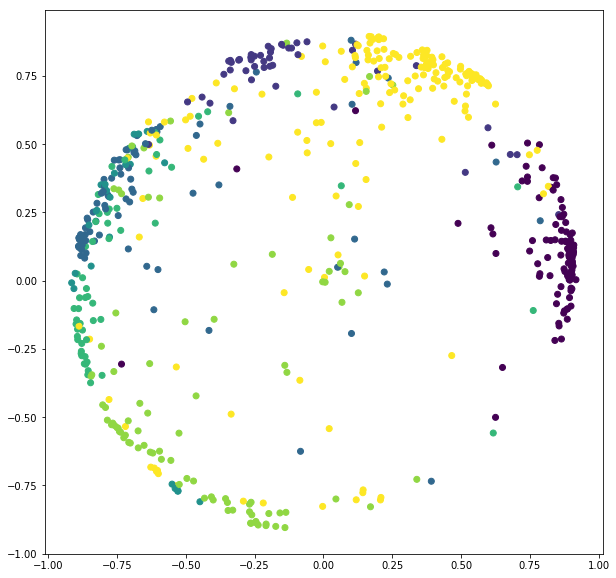

In [19]:
plt.figure(figsize=(10, 10))
plt.scatter(embedding[:,0], embedding[:,1], c = np.array(targets).flatten())
plt.savefig("fig.png")

In [23]:
[X_test, L_test, mask_test], Y_test = gen.next()

In [24]:
X_test.shape, L_test.shape, mask_test.shape

((25, 1433, 1), (25, 25), (25, 7))

In [25]:
predictions = model.predict([X_test, L_test, mask_test], batch_size=X_test.shape[0])

In [26]:
np.concatenate([predictions[:,2:], Y_test], axis=1)

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   7.67073482e-02,
          5.64794242e-01,   1.59292474e-01,   6.10284328e-01,
          2.39640381e-02,   3.39013904e-01,   1.23115987e-01,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   8.90502781e-02,
          5.34350574e-01,   1.51579112e-01,   2.77203053e-01,
          1.32199693e-02,   2.47876480e-01,   3.84735227e-01,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   5.06294426e-03,
          4.98151720e-01,   7.95075521e-02,   2.92400301e-01,
          6.7581

In [27]:
from sklearn.manifold import TSNE

In [28]:
tsne_raw = TSNE()

In [29]:
raw_embedding = tsne_raw.fit_transform(X_test.squeeze())

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

In [31]:
X_test.squeeze()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.]], dtype=float32)

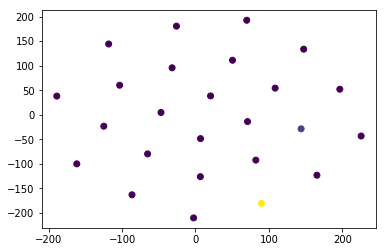

In [32]:
plt.scatter(raw_embedding[:,0], raw_embedding[:,1], c=Y_test.argmax(axis=1))

In [33]:
primary_cap_length = Length()(primary_cap)
embedder = Model([x, L_input], primary_cap_length)

In [40]:
1433 * 32

45856

In [44]:
Lx =L_hat.dot(X.squeeze())

In [46]:
X[0,:,0]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [48]:
Lx[0,:]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [34]:
embedder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
L_input (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
signal_input (InputLayer)       (None, 1433, 1)      0                                            
__________________________________________________________________________________________________
conv1 (GraphConv)               (None, 1433, 32)     45920       L_input[0][0]                    
                                                                 signal_input[0][0]               
__________________________________________________________________________________________________
primarycap_GraphConv (GraphConv (None, 1433, 256)    383232      L_input[0][0]                    
          

In [35]:
embedding = embedder.predict_on_batch([X_test, L_test], )

In [37]:
tsne_embedder = TSNE()

In [38]:
tsne_embedding = tsne_embedder.fit_transform(embedding)

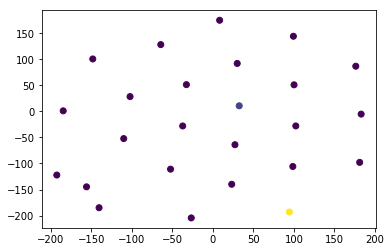

In [39]:
plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=Y_test.argmax(axis=1))